In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import tqdm
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.dates as mdates

PATH_TO_KEY="/content/upbeat-imprint-450110-g2-1457390ebe3e.json"
credentials = service_account.Credentials.from_service_account_file(PATH_TO_KEY)
client = bigquery.Client(credentials= credentials)

In [2]:
POOL_ADDRESS="0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
query='''
SELECT
  TIMESTAMP_TRUNC(block_timestamp, HOUR) AS hour,
  block_number,
  block_timestamp,
  log_index,
  transaction_index,
  CONCAT('0x',(CAST(SUBSTRING(Data, 3, 64) as string))) as amount0,
  CONCAT('0x',(CAST(SUBSTRING(Data, 67, 64) as string))) as amount1,
  CONCAT('0x',(CAST(SUBSTRING(Data, 131, 64) as string))) as sqrtPrice,
  CONCAT('0x',(CAST(SUBSTRING(Data, 195, 64) as string))) as liquidity,
IF
  ((CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) > CAST('0xf00000' AS int), (CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int))- CAST('0xffffff' AS int), CAST(CONCAT('0x',(CAST(SUBSTRING(DATA, 317, 16) AS string))) AS int)) AS tick
FROM
  `bigquery-public-data.crypto_ethereum.logs`
WHERE
  DATA != ""
  AND transaction_hash != ""
  AND address = lower("{}")
  AND (CAST(SUBSTRING(DATA, 259, 64) AS string)) != ''
  AND block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
ORDER BY
  block_timestamp ASC, transaction_index'''.format(POOL_ADDRESS)
print('⏰ performing the query...')

try:
    df = client.query(query).to_dataframe()
    print('🟢 Done!')
except Exception as e:
    print('🟠 There was an issue querying the data!')
    print(e)

⏰ performing the query...
🟢 Done!


In [3]:
df.to_csv('raw_pool_data.csv') # saves df to avoid querying often
#df=pandas.read_csv('raw_pool_data.csv') #uncomment to read df directly.
df.head(10)

,hour,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick
0,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,140,6,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000425ff6d4...,0x00000000000000000000000000000000000000000000...,194819
1,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,199,6,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000425ee9ae...,0x00000000000000000000000000000000000000000000...,194818
2,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,168,6,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000425f5dda...,0x00000000000000000000000000000000000000000000...,194818
3,2025-01-07 15:00:00+00:00,21573552,2025-01-07 15:40:59+00:00,363,118,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000042554ab1...,0x00000000000000000000000000000000000000000000...,194807
4,2025-01-07 15:00:00+00:00,21573560,2025-01-07 15:42:35+00:00,184,7,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x00000000000000000000000000000000000042b342a1...,0x00000000000000000000000000000000000000000000...,194917
5,2025-01-07 15:00:00+00:00,21573561,2025-01-07 15:42:47+00:00,30,6,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000429c6934...,0x00000000000000000000000000000000000000000000...,194890
6,2025-01-07 15:00:00+00:00,21573570,2025-01-07 15:44:35+00:00,88,16,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000429c5ffb...,0x00000000000000000000000000000000000000000000...,194890
7,2025-01-07 15:00:00+00:00,21573571,2025-01-07 15:44:47+00:00,5,1,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000042934e7f...,0x00000000000000000000000000000000000000000000...,194880
8,2025-01-07 15:00:00+00:00,21573594,2025-01-07 15:49:23+00:00,5,1,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x000000000000000000000000000000000000427eac8c...,0x00000000000000000000000000000000000000000000...,194855
9,2025-01-07 15:00:00+00:00,21573596,2025-01-07 15:49:47+00:00,11,3,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x0000000000000000000000000000000000004269d716...,0x00000000000000000000000000000000000000000000...,194831


In [4]:
df.tail(10)

,hour,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick
14635,2025-02-06 15:00:00+00:00,21788307,2025-02-06 15:17:47+00:00,11,3,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004a7e064c...,0x00000000000000000000000000000000000000000000...,197127
14636,2025-02-06 15:00:00+00:00,21788308,2025-02-06 15:17:59+00:00,24,3,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004a91db3a...,0x00000000000000000000000000000000000000000000...,197148
14637,2025-02-06 15:00:00+00:00,21788316,2025-02-06 15:19:35+00:00,8,2,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x0000000000000000000000000000000000004a8d869d...,0x00000000000000000000000000000000000000000000...,197143
14638,2025-02-06 15:00:00+00:00,21788317,2025-02-06 15:19:47+00:00,163,29,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x0000000000000000000000000000000000004a8bda35...,0x00000000000000000000000000000000000000000000...,197141
14639,2025-02-06 15:00:00+00:00,21788318,2025-02-06 15:19:59+00:00,22,4,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x0000000000000000000000000000000000004a872cf2...,0x00000000000000000000000000000000000000000000...,197136
14640,2025-02-06 15:00:00+00:00,21788326,2025-02-06 15:21:35+00:00,2,0,0x00000000000000000000000000000000000000000000...,0xffffffffffffffffffffffffffffffffffffffffffff...,0x0000000000000000000000000000000000004a80cf29...,0x00000000000000000000000000000000000000000000...,197130
14641,2025-02-06 15:00:00+00:00,21788374,2025-02-06 15:31:11+00:00,8,2,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004a92c7f8...,0x00000000000000000000000000000000000000000000...,197149
14642,2025-02-06 15:00:00+00:00,21788379,2025-02-06 15:32:11+00:00,8,2,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004a9f3a7a...,0x00000000000000000000000000000000000000000000...,197162
14643,2025-02-06 15:00:00+00:00,21788380,2025-02-06 15:32:23+00:00,86,10,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004aa45d46...,0x00000000000000000000000000000000000000000000...,197167
14644,2025-02-06 15:00:00+00:00,21788381,2025-02-06 15:32:35+00:00,11,3,0xffffffffffffffffffffffffffffffffffffffffffff...,0x00000000000000000000000000000000000000000000...,0x0000000000000000000000000000000000004ab0838b...,0x00000000000000000000000000000000000000000000...,197180


In [5]:
DIGITS_TOKEN0=6
DIGITS_TOKEN1=18
UNIV3_BASE=1.0001

def convert_price(p: float, dec_0: int, dec_1: int) -> float:
    """Gets inverse price"""
    return 10 ** (dec_1 - dec_0) / p

def get_twos_comp(hex_str, bits: int=256):
    """Calculate two's complement"""
    num = int(hex_str, 16)
    if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
        num = num - (1 << bits)        # Get two's complement
    return num

In [6]:
df['amount0']=df['amount0'].apply(get_twos_comp)/ (10 ** DIGITS_TOKEN0)
df['amount1']=df['amount1'].apply(get_twos_comp)/ (10 ** DIGITS_TOKEN1)
#Computes sqrt in terms of token0
df['sqrtPrice']=df['sqrtPrice'].apply(get_twos_comp)//(2**96)
df['price'] = df['tick'].apply(lambda x: convert_price(UNIV3_BASE**x,DIGITS_TOKEN0,DIGITS_TOKEN1))
df.head(5)

,hour,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick,price
0,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,140,6,508.350990,-0.146335,16991,0x00000000000000000000000000000000000000000000...,194819,3463.708608
1,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,199,6,1999.649107,-0.575564,16990,0x00000000000000000000000000000000000000000000...,194818,3464.054979
2,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,168,6,2633.044499,-0.757923,16991,0x00000000000000000000000000000000000000000000...,194818,3464.054979
3,2025-01-07 15:00:00+00:00,21573552,2025-01-07 15:40:59+00:00,363,118,42420.329300,-12.20272,16981,0x00000000000000000000000000000000000000000000...,194807,3467.867345
4,2025-01-07 15:00:00+00:00,21573560,2025-01-07 15:42:35+00:00,184,7,-393670.342994,114.488758,17075,0x00000000000000000000000000000000000000000000...,194917,3429.931729


In [7]:
pr_inv=df['sqrtPrice']*10**((DIGITS_TOKEN0-DIGITS_TOKEN1)/2)
df['sqrtPrice']=1/pr_inv
df.head(5)

,hour,block_number,block_timestamp,log_index,transaction_index,amount0,amount1,sqrtPrice,liquidity,tick,price
0,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,140,6,508.350990,-0.146335,58.854688,0x00000000000000000000000000000000000000000000...,194819,3463.708608
1,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,199,6,1999.649107,-0.575564,58.858152,0x00000000000000000000000000000000000000000000...,194818,3464.054979
2,2025-01-07 15:00:00+00:00,21573549,2025-01-07 15:40:23+00:00,168,6,2633.044499,-0.757923,58.854688,0x00000000000000000000000000000000000000000000...,194818,3464.054979
3,2025-01-07 15:00:00+00:00,21573552,2025-01-07 15:40:59+00:00,363,118,42420.329300,-12.20272,58.889347,0x00000000000000000000000000000000000000000000...,194807,3467.867345
4,2025-01-07 15:00:00+00:00,21573560,2025-01-07 15:42:35+00:00,184,7,-393670.342994,114.488758,58.565154,0x00000000000000000000000000000000000000000000...,194917,3429.931729


In [8]:
df.to_csv('cleaned_uniswap.csv')

In [9]:

import pandas as pd

# Load the dataset
file_path = "cleaned_uniswap.csv"
df = pd.read_csv(file_path)


df['hour'] = pd.to_datetime(df['hour'])

# Group by hour and calculate OHLC for the price column
ohlc_data = df.groupby('hour')['price'].agg(['first', 'max', 'min', 'last']).reset_index()

# Rename columns to standard OHLC naming
ohlc_data.columns = ['hour', 'open', 'high', 'low', 'close']

ohlc_file_path = "/mnt/data/uniswap_ohlc_1h.csv"
ohlc_data.to_csv('1.csv')

ohlc_data.head()


,hour,open,high,low,close
0,2025-01-07 15:00:00+00:00,3463.708608,3467.867345,3429.931729,3465.440809
1,2025-01-07 16:00:00+00:00,3461.631110,3478.633875,3461.284981,3469.601625
2,2025-01-07 17:00:00+00:00,3469.601625,3469.601625,3431.990203,3437.829256
3,2025-01-07 18:00:00+00:00,3440.924540,3446.089542,3421.368037,3421.368037
4,2025-01-07 19:00:00+00:00,3425.475938,3425.818485,3390.376364,3390.376364


In [10]:
Uniswap_ohlc = ohlc_data

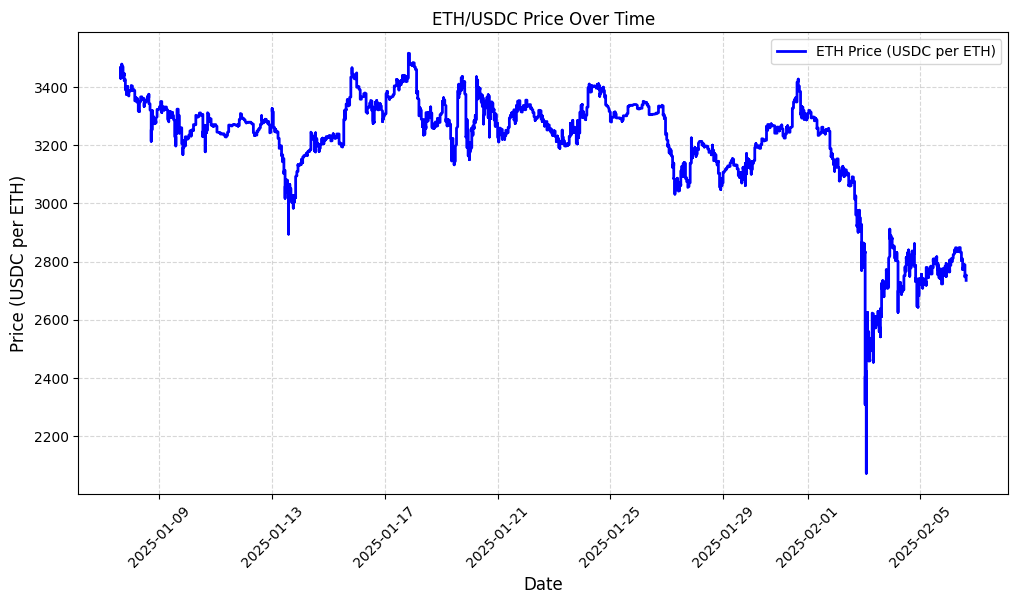

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot Price (USDC per ETH) vs Date
plt.figure(figsize=(12, 6))
plt.plot(df['hour'], df['price'], label="ETH Price (USDC per ETH)", color='blue', linewidth = 2)

# Formatting
plt.xlabel("Date",fontsize = 12)
plt.ylabel("Price (USDC per ETH)",fontsize = 12)
plt.title("ETH/USDC Price Over Time",fontsize = 12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


#Now lets extract the data through CoinMarketCap

In [12]:
cmc_api_key = "c605f9c7-39c5-4b1e-8de1-b8a222a2f0e5"

In [26]:
# !pip install requests pandas

✅ CoinMarketCap data saved successfully!


<ipython-input-51-99c6f8ad0800>:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


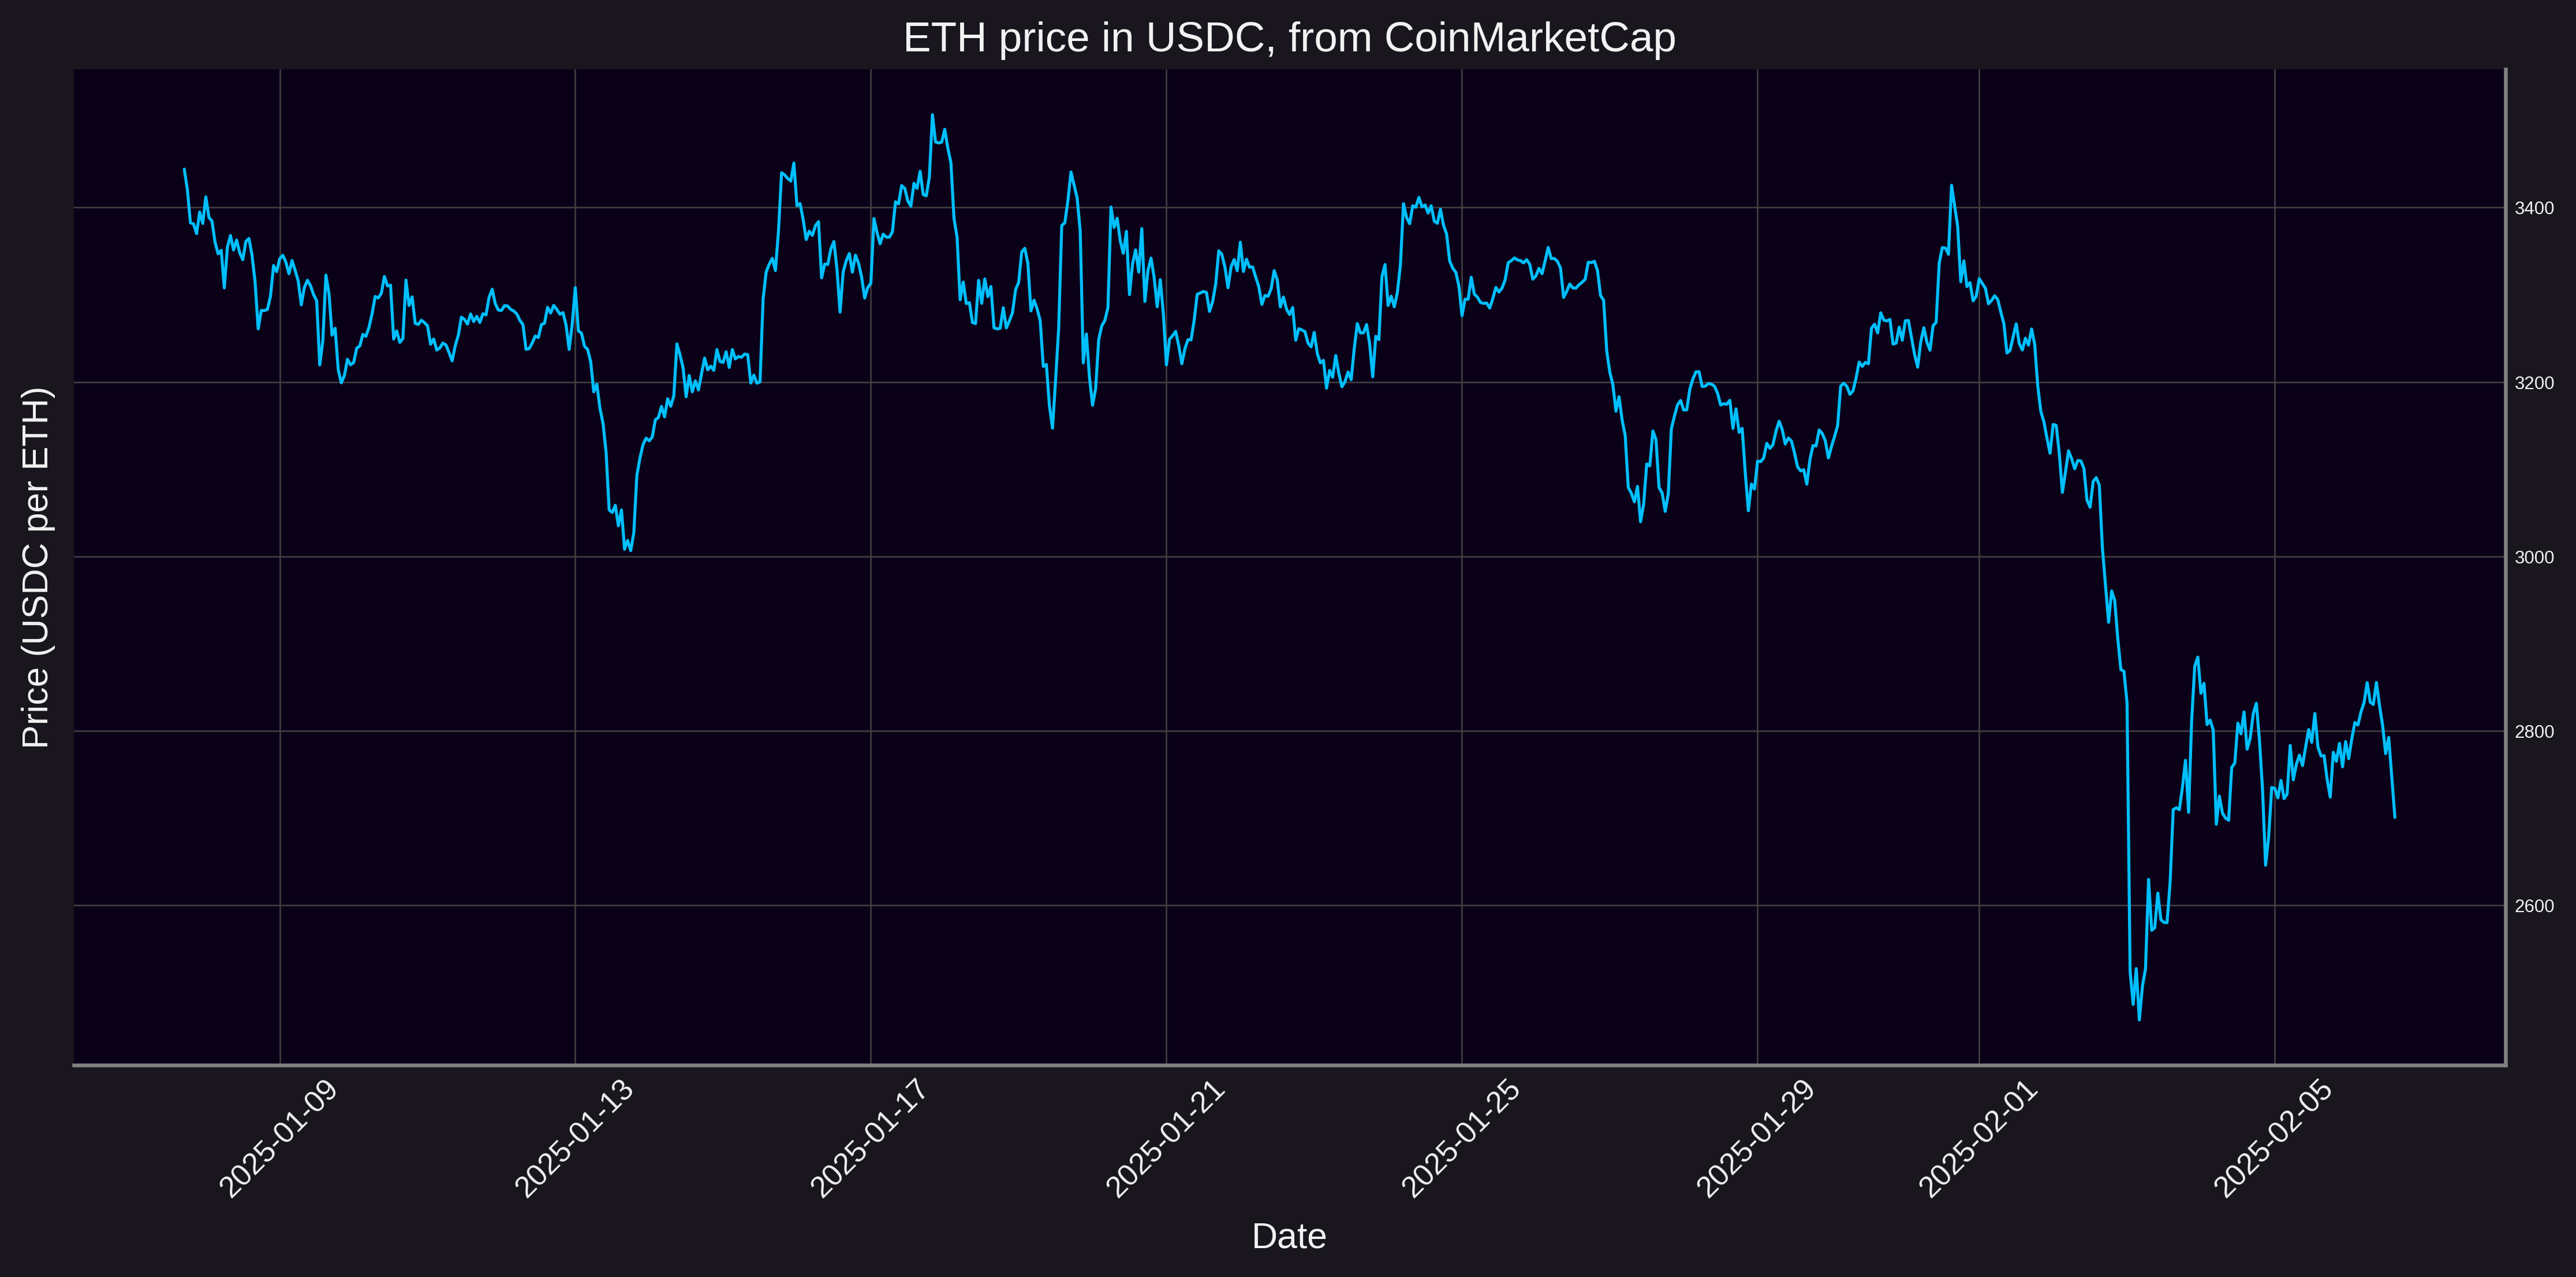

In [51]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, timezone

# 🔹 Apply your custom style
plt.style.use('panoptic-dark-2_1.mplstyle')

# CoinMarketCap API Setup
API_KEY = cmc_api_key
URL = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/ohlcv/historical"

# Define Time Period (Past 30 Days)
end_time = datetime.now(timezone.utc)
start_time = end_time - timedelta(days=30)

# Format time as ISO 8601 (required by CoinMarketCap API)
time_start_str = start_time.strftime('%Y-%m-%dT%H:%M:%SZ')
time_end_str = end_time.strftime('%Y-%m-%dT%H:%M:%SZ')

# API Parameters
params = {
    "id": 1027,  # Ethereum's CoinMarketCap ID
    "convert": "USDC",
    "time_start": time_start_str,
    "time_end": time_end_str,
    "time_period": "hourly",
    "interval": "1h"  # Lowercase "h" for hourly interval
}

headers = {"X-CMC_PRO_API_KEY": API_KEY}

# Fetch Data from CoinMarketCap API
response = requests.get(URL, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()["data"]["quotes"]

    processed_data = []
    for entry in data:
        timestamp = datetime.strptime(entry["time_open"], "%Y-%m-%dT%H:%M:%S.%fZ").replace(tzinfo=timezone.utc)
        formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S%z')  # Convert to required format
        ohlc = entry["quote"]["USDC"]

        processed_data.append([
            formatted_timestamp,  # Formatted Timestamp
            ohlc["open"],  # Open Price
            ohlc["high"],  # High Price
            ohlc["low"],   # Low Price
            ohlc["close"],  # Close Price
            ohlc.get("volume", 0),  # Volume (if available)
            ohlc["close"]  # Equivalent to Uniswap's `price`
        ])

    # Convert Data to Pandas DataFrame
    df_cmc = pd.DataFrame(processed_data, columns=["Timestamp", "Open", "High", "Low", "Close", "Volume", "price"])

    # Save Data as CSV with the correct timestamp format
    df_cmc.to_csv("eth_usdc_ohlc_30days_cmc.csv", index=False)
    print("✅ CoinMarketCap data saved successfully!")

    # 🔹 Generate Line Chart with Custom Style
    df_cmc["Timestamp"] = pd.to_datetime(df_cmc["Timestamp"])  # Convert to datetime for plotting
    df_cmc.set_index("Timestamp", inplace=True)  # Set index for plotting

    plt.figure(figsize=(12, 6))
    plt.plot(df_cmc.index, df_cmc["price"], color="deepskyblue", linewidth=1)

    # Customizations
    plt.title("ETH price in USDC, from CoinMarketCap", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price (USDC per ETH)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(visible=True)

    # Show Plot
    plt.tight_layout()
    plt.show()

else:
    print(f"❌ Error: {response.status_code}, {response.text}")


In [14]:
df_cmc.head()

,Open,High,Low,Close,Volume,price
Timestamp,,,,,,
2025-01-07 16:00:00+00:00,3466.575689,3490.055257,3451.996226,3460.731914,2.674535e+10,3460.731914
2025-01-07 17:00:00+00:00,3459.813687,3468.764547,3419.708557,3443.779064,2.734356e+10,3443.779064
2025-01-07 18:00:00+00:00,3444.022848,3457.332444,3413.339004,3420.428592,2.783882e+10,3420.428592
2025-01-07 19:00:00+00:00,3420.132912,3435.383417,3379.925000,3382.254017,2.947766e+10,3382.254017
2025-01-07 20:00:00+00:00,3384.304372,3397.462390,3366.275918,3381.126416,3.047348e+10,3381.126416


In [15]:
df_cmc.tail()

,Open,High,Low,Close,Volume,price
Timestamp,,,,,,
2025-02-06 10:00:00+00:00,2856.138185,2855.932442,2823.511480,2829.359309,2.921086e+10,2829.359309
2025-02-06 11:00:00+00:00,2829.760739,2831.481094,2795.662761,2806.670815,2.894153e+10,2806.670815
2025-02-06 12:00:00+00:00,2806.620931,2808.423741,2772.766903,2773.973987,2.931505e+10,2773.973987
2025-02-06 13:00:00+00:00,2774.444061,2799.683118,2769.178524,2792.534402,3.012591e+10,2792.534402
2025-02-06 14:00:00+00:00,2792.877413,2796.991265,2741.513249,2747.041997,2.772353e+10,2747.041997


# Now we have OHLC data from both the platform Uniswap and CoinMarket Cap. Lets compare them and figure out the discrepencies in them.

In [16]:
CMC_ohlc = df_cmc.drop(columns=['Volume','price'])

In [17]:
CMC_ohlc.head()

,Open,High,Low,Close
Timestamp,,,,
2025-01-07 16:00:00+00:00,3466.575689,3490.055257,3451.996226,3460.731914
2025-01-07 17:00:00+00:00,3459.813687,3468.764547,3419.708557,3443.779064
2025-01-07 18:00:00+00:00,3444.022848,3457.332444,3413.339004,3420.428592
2025-01-07 19:00:00+00:00,3420.132912,3435.383417,3379.925000,3382.254017
2025-01-07 20:00:00+00:00,3384.304372,3397.462390,3366.275918,3381.126416


In [18]:
CMC_ohlc.rename(columns={'Open':'cmc_open','High':'cmc_high','Low':'cmc_low','Close': 'cmc_close'},inplace = True)

In [19]:
CMC_ohlc.head()

,cmc_open,cmc_high,cmc_low,cmc_close
Timestamp,,,,
2025-01-07 16:00:00+00:00,3466.575689,3490.055257,3451.996226,3460.731914
2025-01-07 17:00:00+00:00,3459.813687,3468.764547,3419.708557,3443.779064
2025-01-07 18:00:00+00:00,3444.022848,3457.332444,3413.339004,3420.428592
2025-01-07 19:00:00+00:00,3420.132912,3435.383417,3379.925000,3382.254017
2025-01-07 20:00:00+00:00,3384.304372,3397.462390,3366.275918,3381.126416


In [20]:
CMC_ohlc = CMC_ohlc.reset_index()


In [21]:
CMC_ohlc.head()

,Timestamp,cmc_open,cmc_high,cmc_low,cmc_close
0,2025-01-07 16:00:00+00:00,3466.575689,3490.055257,3451.996226,3460.731914
1,2025-01-07 17:00:00+00:00,3459.813687,3468.764547,3419.708557,3443.779064
2,2025-01-07 18:00:00+00:00,3444.022848,3457.332444,3413.339004,3420.428592
3,2025-01-07 19:00:00+00:00,3420.132912,3435.383417,3379.925000,3382.254017
4,2025-01-07 20:00:00+00:00,3384.304372,3397.462390,3366.275918,3381.126416


In [22]:
Uniswap_ohlc.head()

,hour,open,high,low,close
0,2025-01-07 15:00:00+00:00,3463.708608,3467.867345,3429.931729,3465.440809
1,2025-01-07 16:00:00+00:00,3461.631110,3478.633875,3461.284981,3469.601625
2,2025-01-07 17:00:00+00:00,3469.601625,3469.601625,3431.990203,3437.829256
3,2025-01-07 18:00:00+00:00,3440.924540,3446.089542,3421.368037,3421.368037
4,2025-01-07 19:00:00+00:00,3425.475938,3425.818485,3390.376364,3390.376364


In [23]:
Uniswap_ohlc.rename(columns={'hour':'Timestamp'},inplace=True)

In [24]:
Uniswap_ohlc.rename(columns={'open':'uniswap_open','high':'uniswap_high','low':'uniswap_low','close': 'uniswap_close'},inplace = True)

In [25]:
Uniswap_ohlc.head()

,Timestamp,uniswap_open,uniswap_high,uniswap_low,uniswap_close
0,2025-01-07 15:00:00+00:00,3463.708608,3467.867345,3429.931729,3465.440809
1,2025-01-07 16:00:00+00:00,3461.631110,3478.633875,3461.284981,3469.601625
2,2025-01-07 17:00:00+00:00,3469.601625,3469.601625,3431.990203,3437.829256
3,2025-01-07 18:00:00+00:00,3440.924540,3446.089542,3421.368037,3421.368037
4,2025-01-07 19:00:00+00:00,3425.475938,3425.818485,3390.376364,3390.376364


In [26]:
merged_df = pd.merge(Uniswap_ohlc, CMC_ohlc, on='Timestamp')

In [27]:
merged_df.head()

,Timestamp,uniswap_open,uniswap_high,uniswap_low,uniswap_close,cmc_open,cmc_high,cmc_low,cmc_close
0,2025-01-07 16:00:00+00:00,3461.631110,3478.633875,3461.284981,3469.601625,3466.575689,3490.055257,3451.996226,3460.731914
1,2025-01-07 17:00:00+00:00,3469.601625,3469.601625,3431.990203,3437.829256,3459.813687,3468.764547,3419.708557,3443.779064
2,2025-01-07 18:00:00+00:00,3440.924540,3446.089542,3421.368037,3421.368037,3444.022848,3457.332444,3413.339004,3420.428592
3,2025-01-07 19:00:00+00:00,3425.475938,3425.818485,3390.376364,3390.376364,3420.132912,3435.383417,3379.925000,3382.254017
4,2025-01-07 20:00:00+00:00,3386.649186,3386.987851,3374.142362,3384.279480,3384.304372,3397.462390,3366.275918,3381.126416


In [28]:
merged_df['diff_open'] = abs(merged_df['uniswap_open'] - merged_df['cmc_open'])
merged_df['diff_high'] = abs(merged_df['uniswap_high'] - merged_df['cmc_high'])
merged_df['diff_low'] = abs(merged_df['uniswap_low'] - merged_df['cmc_low'])
merged_df['diff_close'] = abs(merged_df['uniswap_close'] - merged_df['cmc_close'])

In [29]:
merged_df.head()

,Timestamp,uniswap_open,uniswap_high,uniswap_low,uniswap_close,cmc_open,cmc_high,cmc_low,cmc_close,diff_open,diff_high,diff_low,diff_close
0,2025-01-07 16:00:00+00:00,3461.631110,3478.633875,3461.284981,3469.601625,3466.575689,3490.055257,3451.996226,3460.731914,4.944579,11.421382,9.288755,8.869712
1,2025-01-07 17:00:00+00:00,3469.601625,3469.601625,3431.990203,3437.829256,3459.813687,3468.764547,3419.708557,3443.779064,9.787938,0.837079,12.281646,5.949808
2,2025-01-07 18:00:00+00:00,3440.924540,3446.089542,3421.368037,3421.368037,3444.022848,3457.332444,3413.339004,3420.428592,3.098308,11.242903,8.029033,0.939445
3,2025-01-07 19:00:00+00:00,3425.475938,3425.818485,3390.376364,3390.376364,3420.132912,3435.383417,3379.925000,3382.254017,5.343025,9.564931,10.451364,8.122346
4,2025-01-07 20:00:00+00:00,3386.649186,3386.987851,3374.142362,3384.279480,3384.304372,3397.462390,3366.275918,3381.126416,2.344815,10.474538,7.866443,3.153064


<ipython-input-30-b6fcc6105520>:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


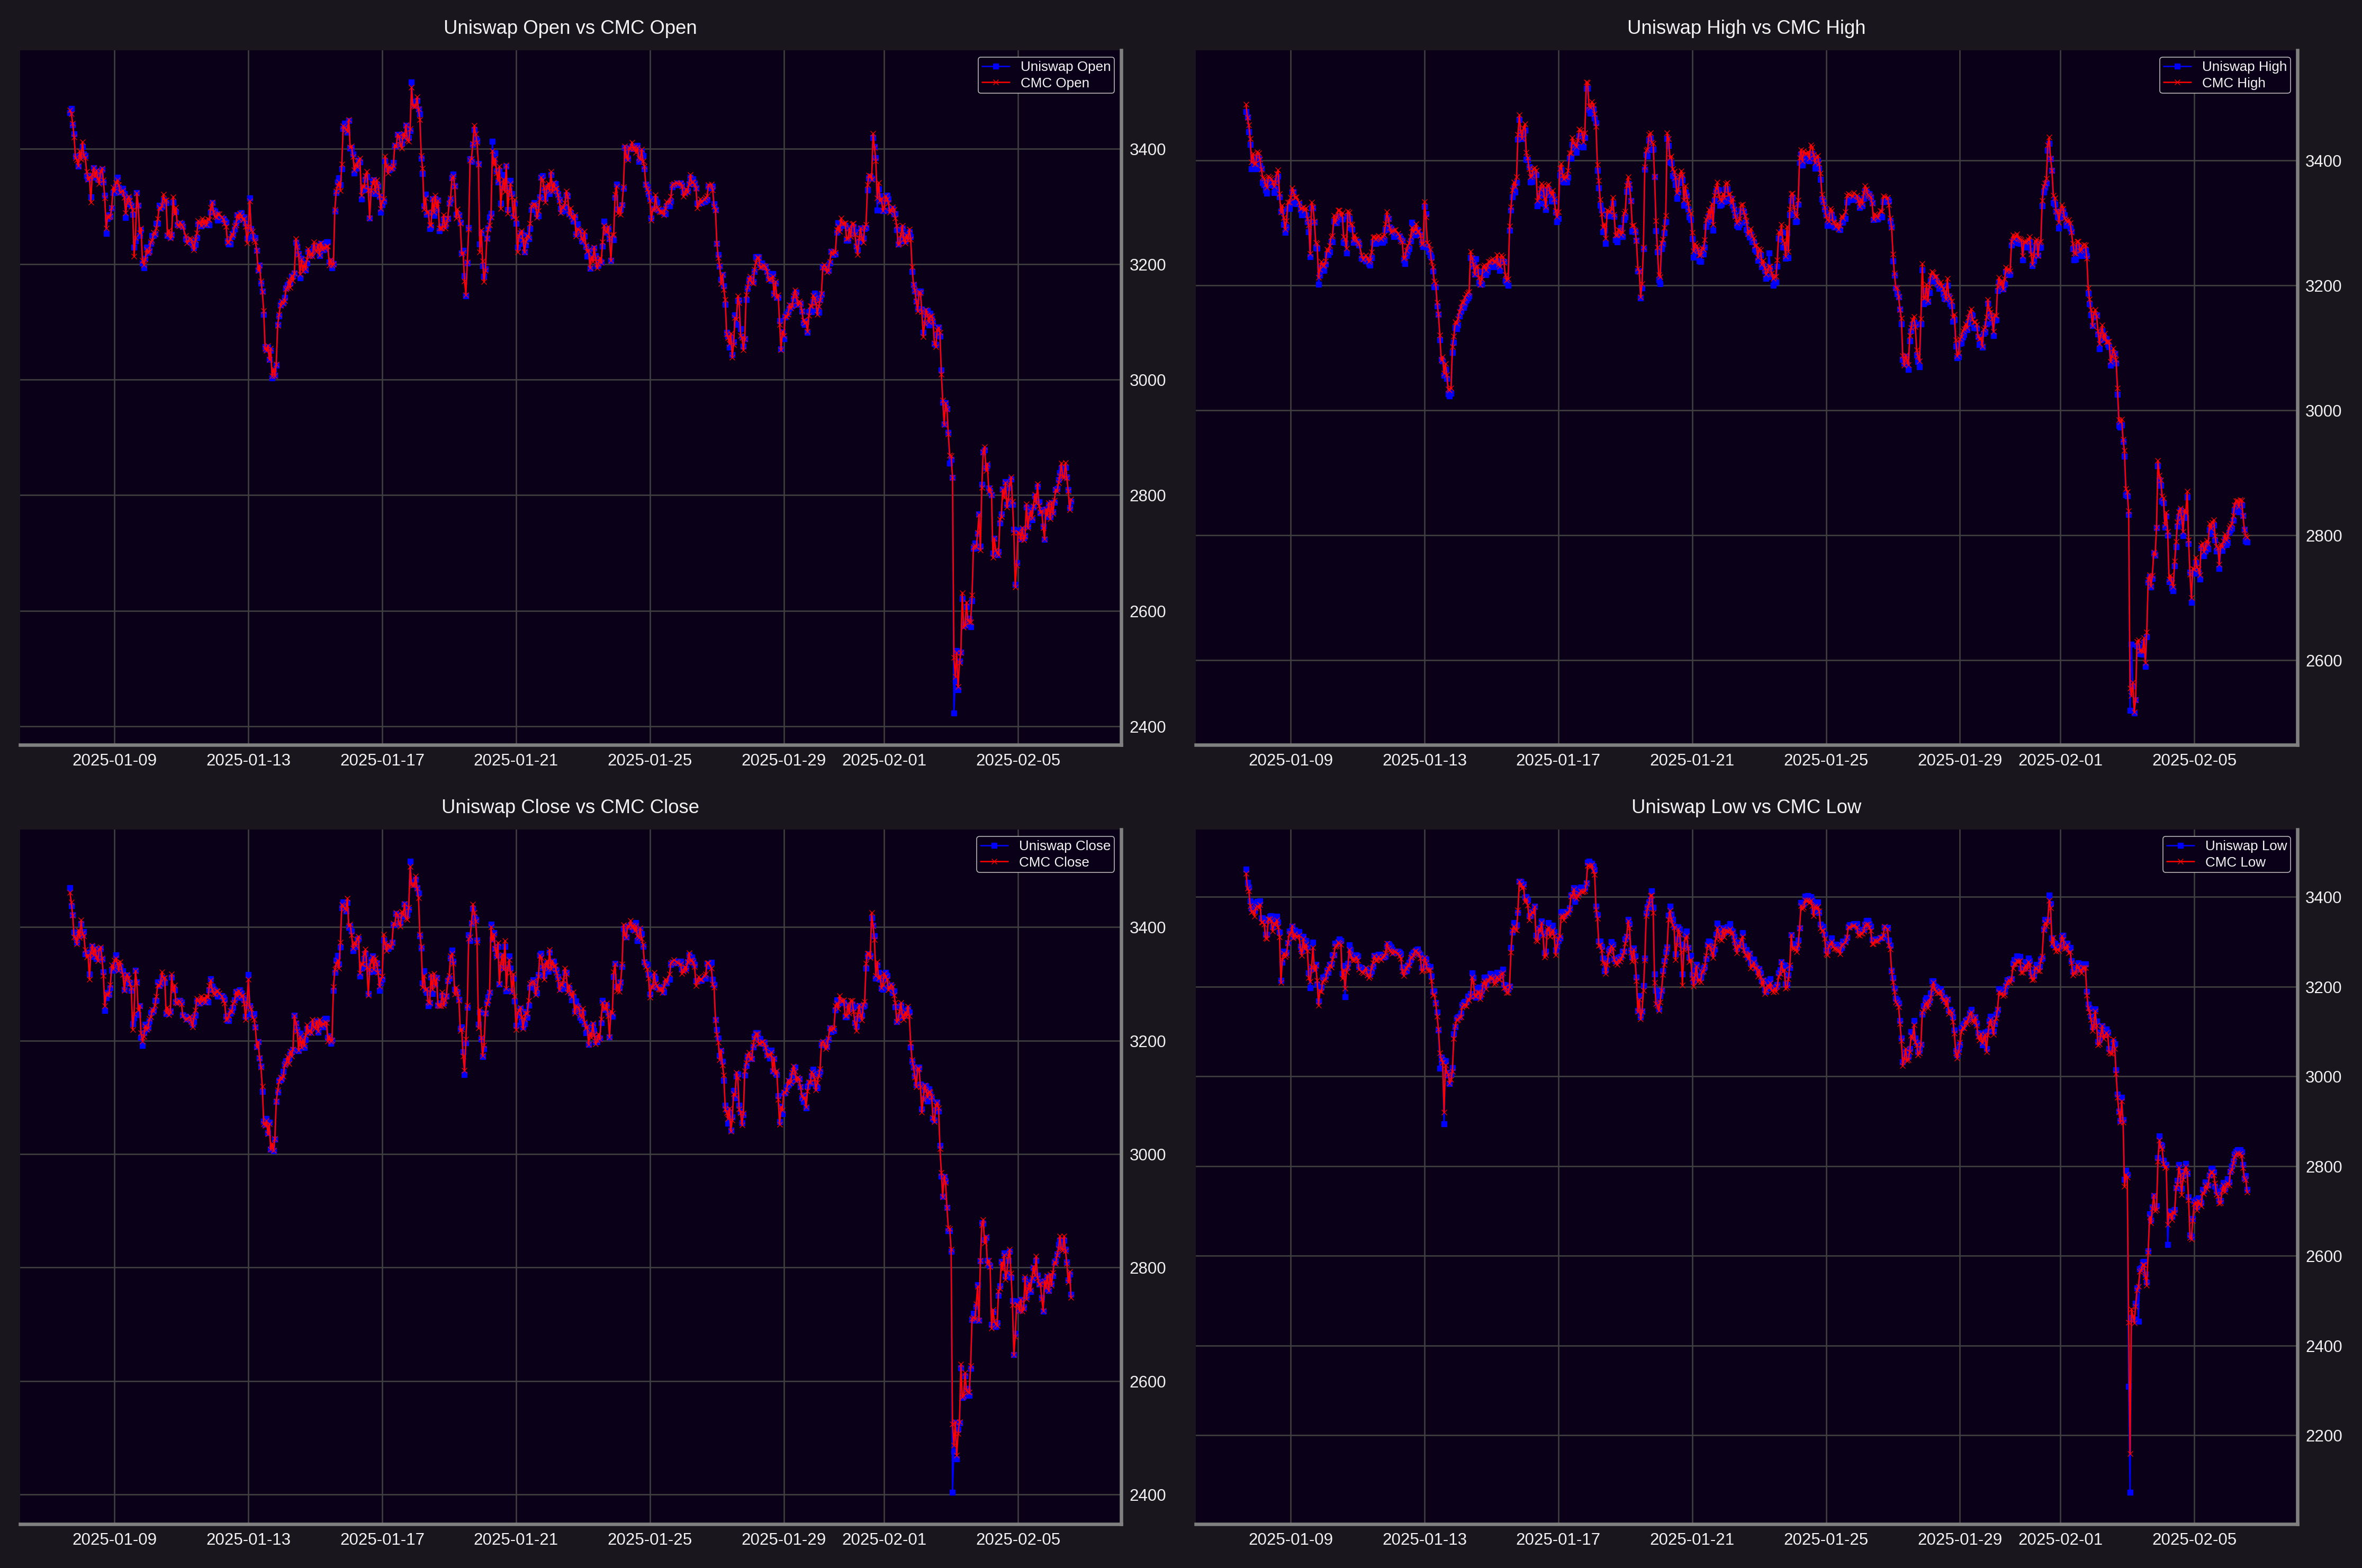

In [30]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: uniswap_open vs cmc_open
axes[0, 0].plot(merged_df["Timestamp"], merged_df["uniswap_open"], label='Uniswap Open', marker='s',color = 'Blue')
axes[0, 0].plot(merged_df["Timestamp"], merged_df["cmc_open"], label='CMC Open', marker='x',color = 'Red')
axes[0, 0].set_title("Uniswap Open vs CMC Open")
axes[0, 0].legend()

# Plot 2: uniswap_high vs cmc_high
axes[0, 1].plot(merged_df["Timestamp"], merged_df["uniswap_high"], label='Uniswap High', marker='s',color = 'Blue')
axes[0, 1].plot(merged_df["Timestamp"], merged_df["cmc_high"], label='CMC High', marker='x',color = 'Red')
axes[0, 1].set_title("Uniswap High vs CMC High")
axes[0, 1].legend()

# Plot 3: uniswap_low vs cmc_low
axes[1, 1].plot(merged_df["Timestamp"], merged_df["uniswap_low"], label='Uniswap Low', marker='s',color = 'Blue')
axes[1, 1].plot(merged_df["Timestamp"], merged_df["cmc_low"], label='CMC Low', marker='x',color = 'Red')
axes[1, 1].set_title("Uniswap Low vs CMC Low")
axes[1, 1].legend()

# Plot 4: uniswap_close vs cmc_close
axes[1, 0].plot(merged_df["Timestamp"], merged_df["uniswap_close"], label='Uniswap Close', marker='s',color = 'Blue')
axes[1, 0].plot(merged_df["Timestamp"], merged_df["cmc_close"], label='CMC Close', marker='x',color = 'Red')
axes[1, 0].set_title("Uniswap Close vs CMC Close")
axes[1, 0].legend()



plt.tight_layout()
plt.show()


<ipython-input-31-fd3672bd9c89>:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


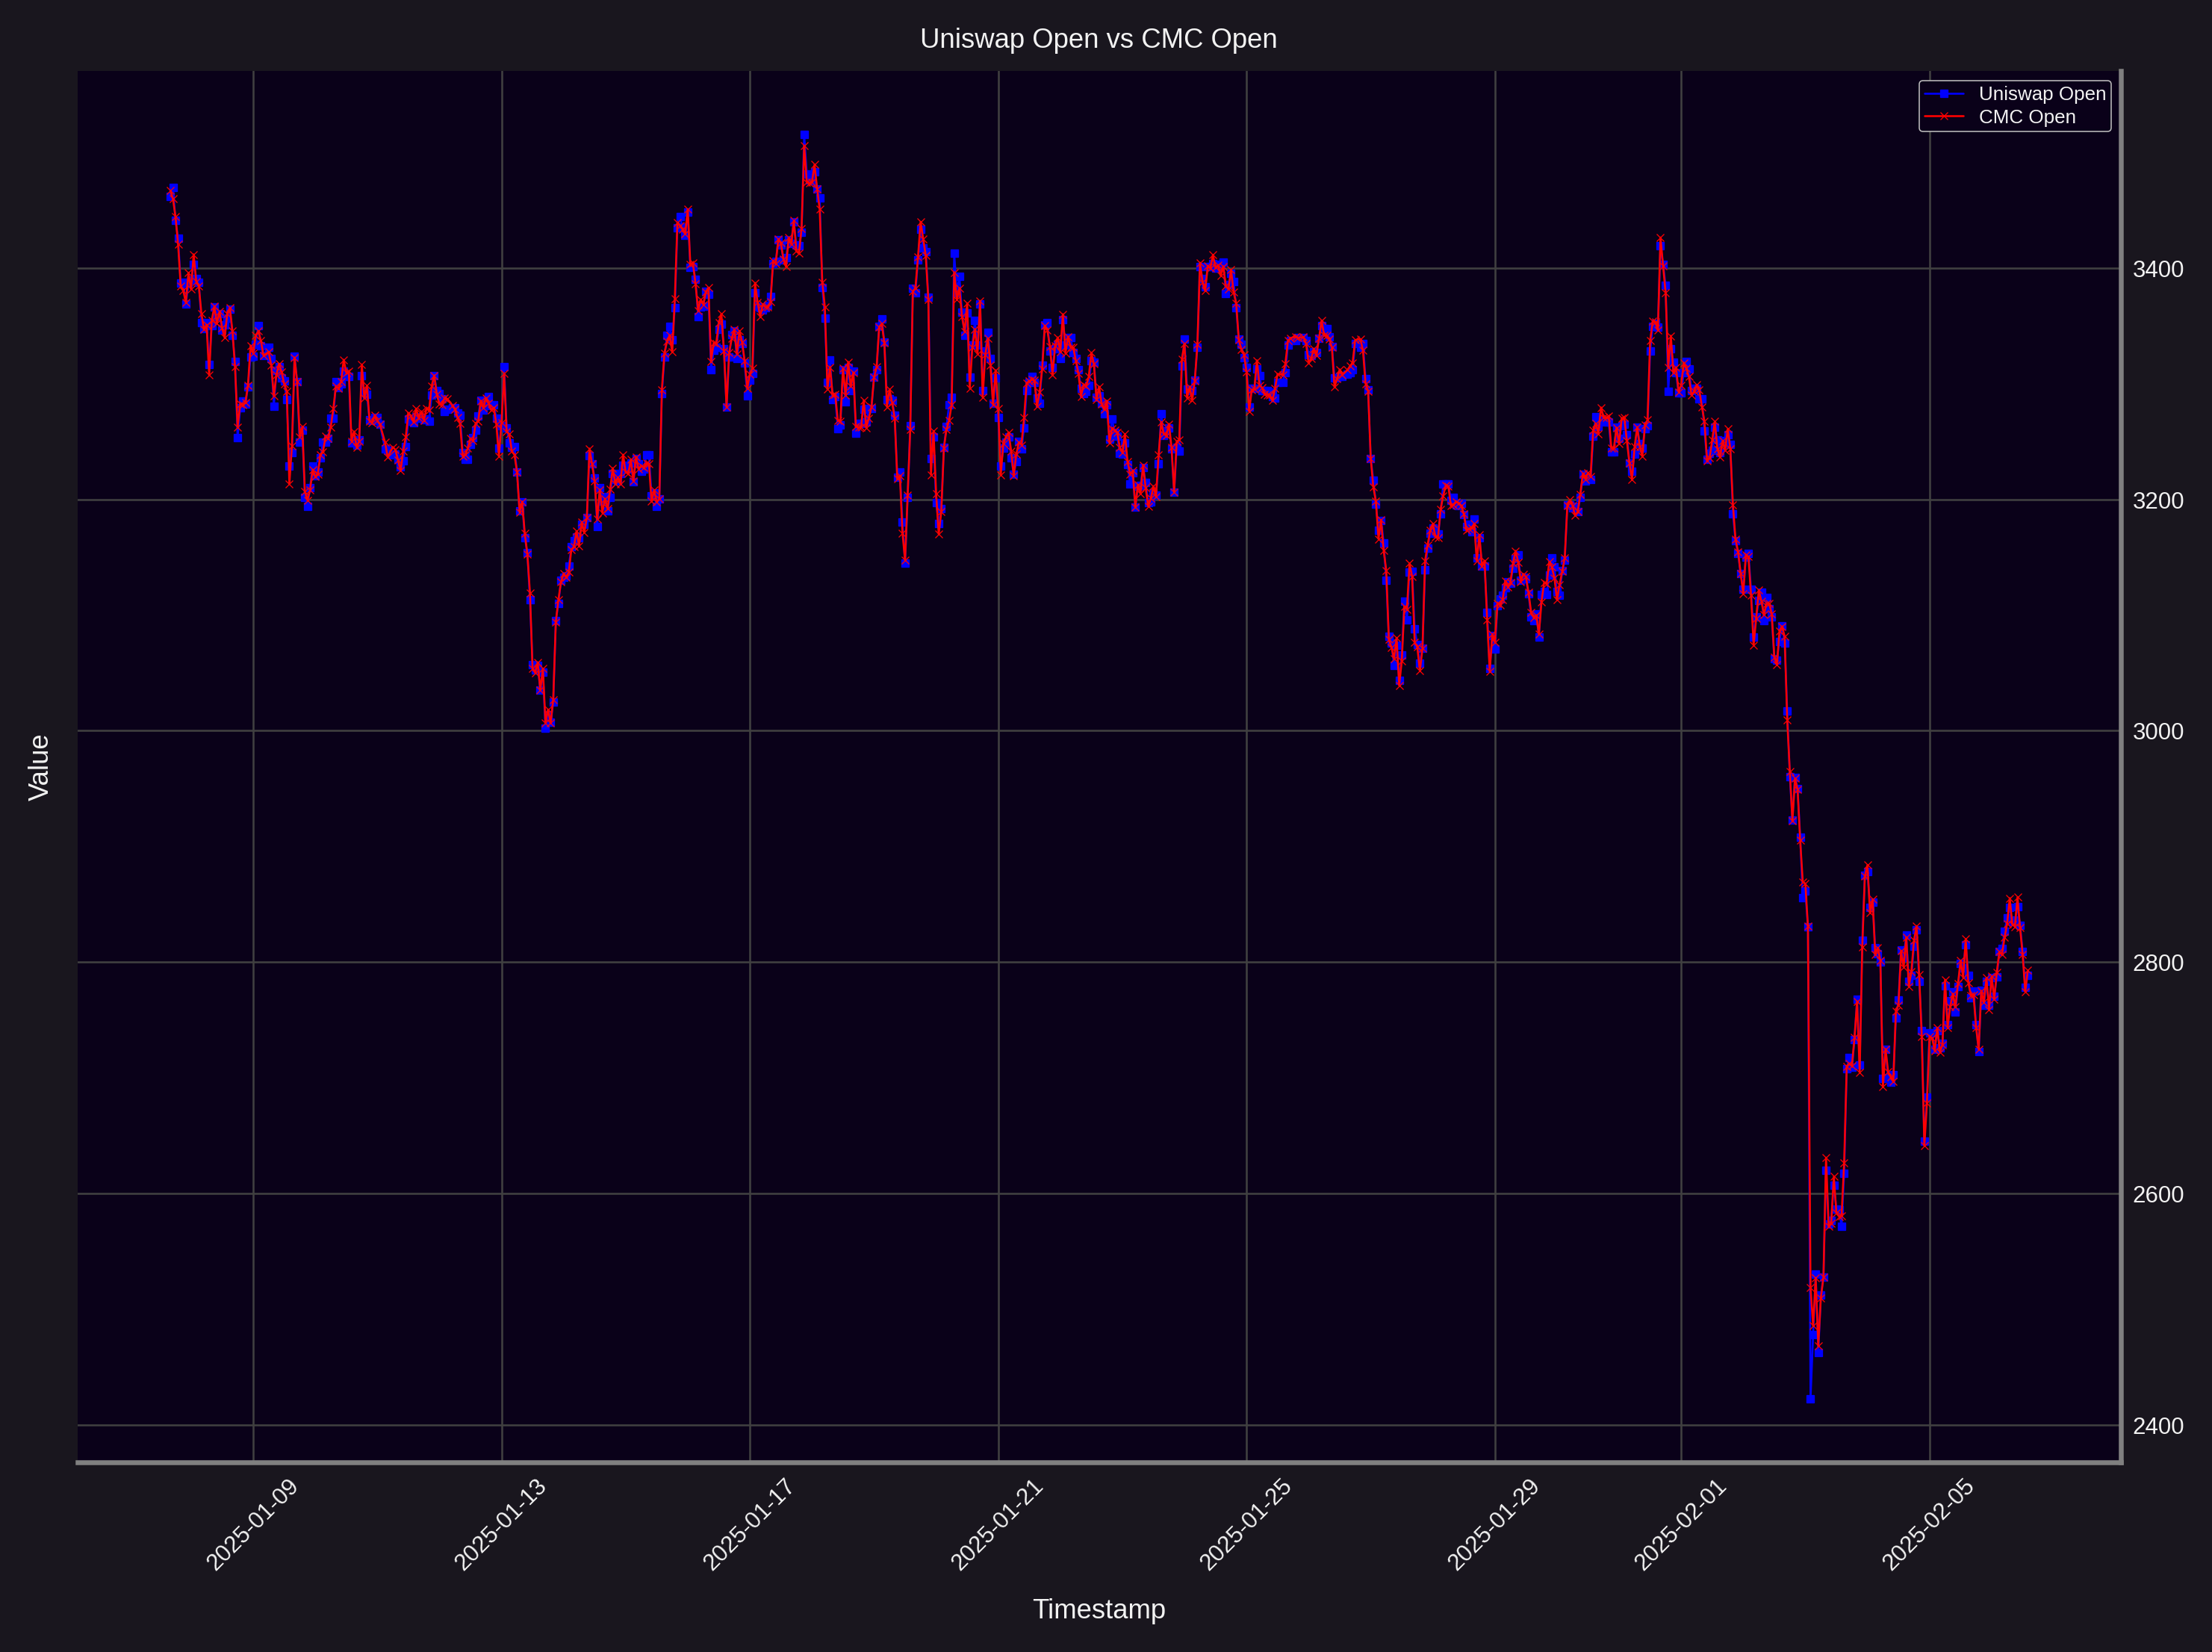

In [31]:
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded
plt.figure(figsize=(8, 6))

# Plot Uniswap Open vs CMC Open
plt.plot(merged_df["Timestamp"], merged_df["uniswap_open"], label='Uniswap Open', marker='s', color='Blue')
plt.plot(merged_df["Timestamp"], merged_df["cmc_open"], label='CMC Open', marker='x', color='Red')

# Title and labels
plt.title("Uniswap Open vs CMC Open")
plt.xlabel("Timestamp")
plt.ylabel("Value")

# Adding legend
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


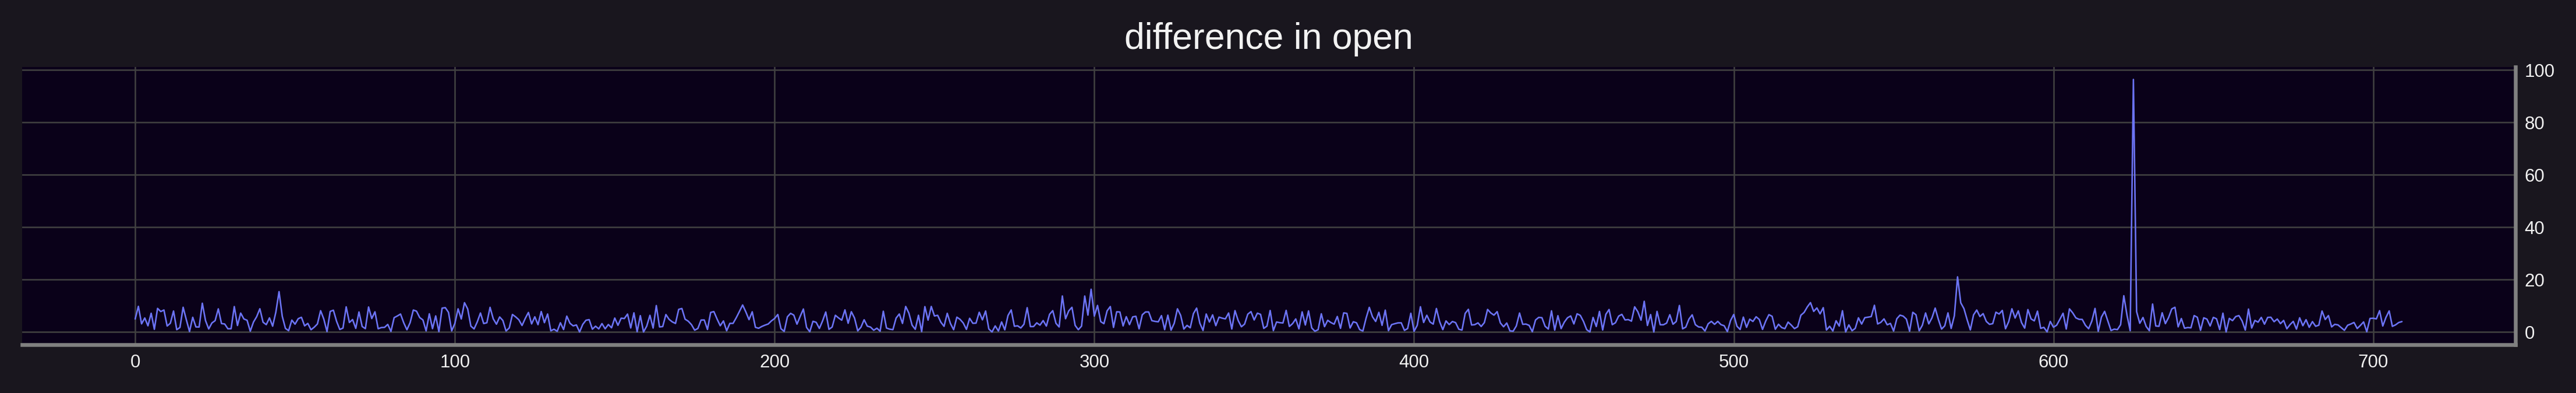

In [42]:
plt.figure(figsize=(12, 2))
plt.title('difference in open',fontsize =12)
plt.plot(merged_df['diff_open'])
plt.show()

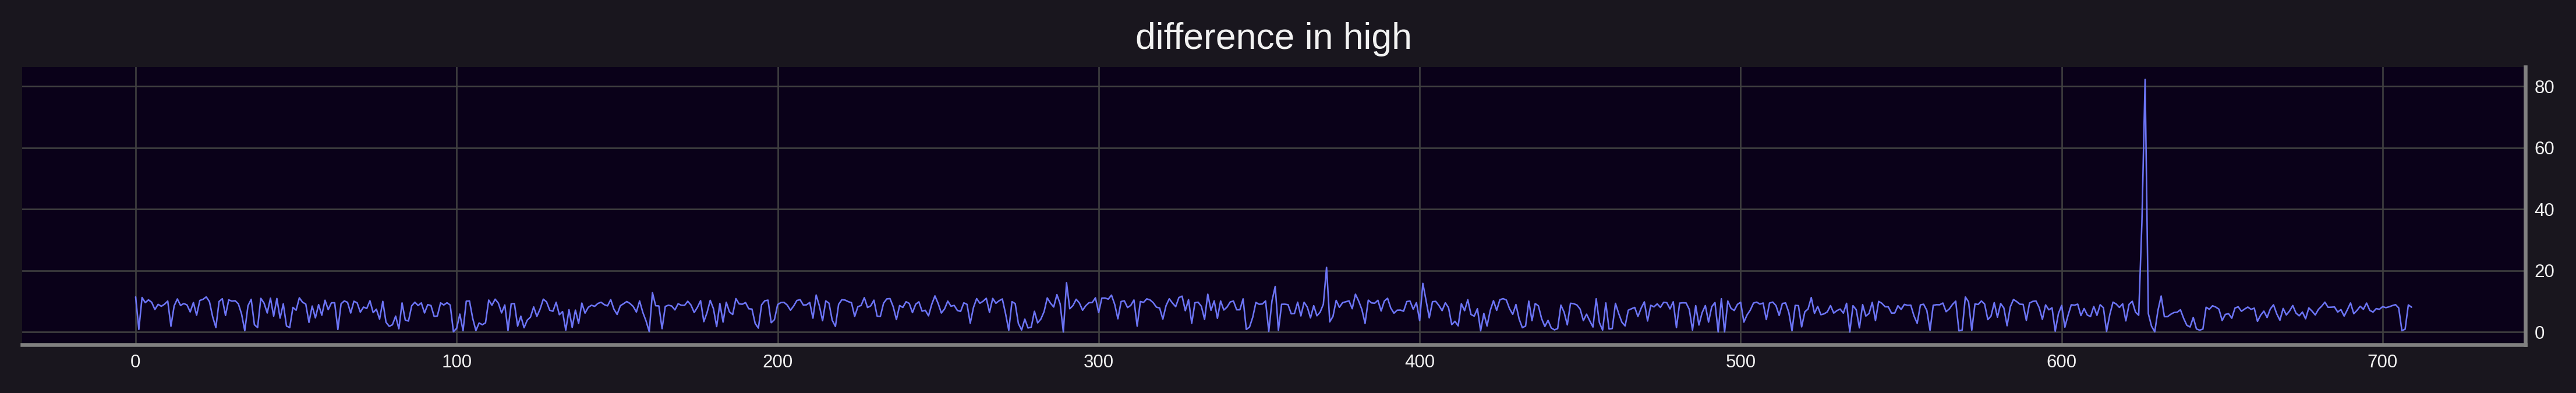

In [44]:
plt.figure(figsize=(12, 2))
plt.title('difference in high',fontsize =12)
plt.plot(merged_df['diff_high'])
plt.show()

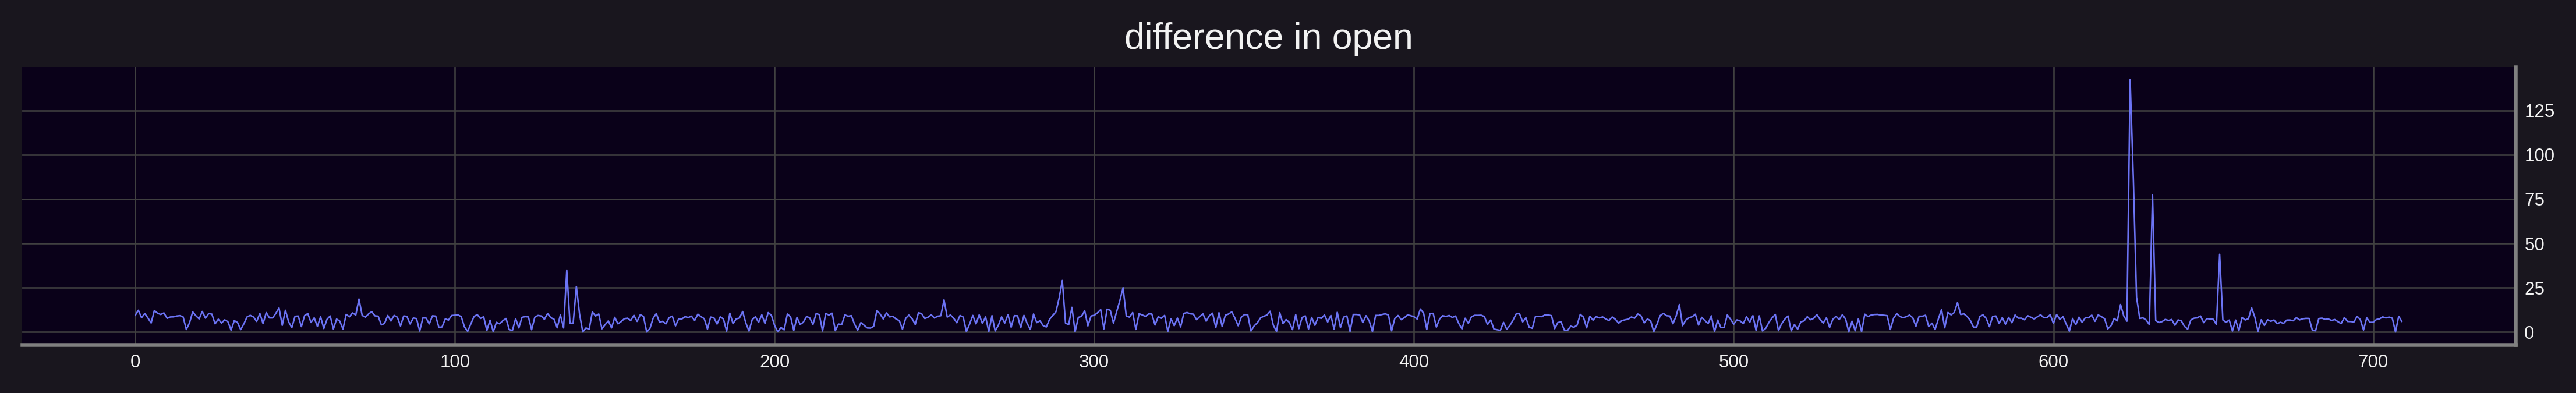

In [39]:
plt.figure(figsize=(12, 2))
plt.title('difference in open',fontsize=12)
plt.plot(merged_df['diff_low'])
plt.show()

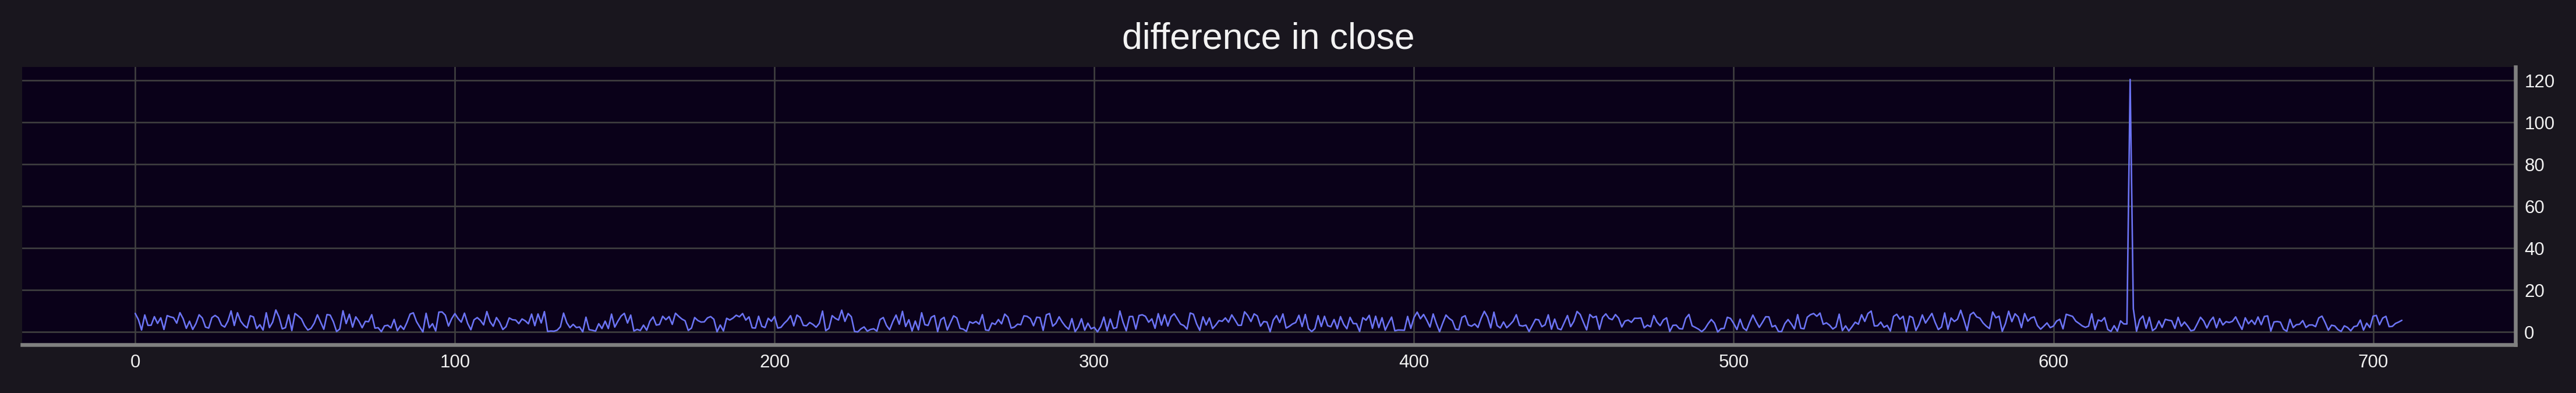

In [52]:
plt.figure(figsize=(12, 2))
plt.title('difference in close',fontsize =12)
plt.plot(merged_df['diff_close'])
plt.show()

In [46]:
merged_df.describe()

,uniswap_open,uniswap_high,uniswap_low,uniswap_close,cmc_open,cmc_high,cmc_low,cmc_close,diff_open,diff_high,diff_low,diff_close
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,3198.146049,3209.754116,3184.104277,3197.190999,3198.561227,3216.340379,3178.771083,3197.645941,4.485647,7.403663,7.529811,4.752714
std,197.315739,192.622327,205.638428,197.891424,196.908974,193.221079,203.117714,197.394781,4.507731,4.280340,7.527539,5.140303
min,2422.397484,2514.957415,2072.313364,2403.577220,2468.482072,2516.845225,2159.038038,2468.810432,0.000070,0.009366,0.012514,0.001893
25%,3152.023403,3164.339632,3141.089868,3150.054412,3151.894154,3173.051826,3138.761335,3150.437994,2.095366,5.479967,4.820275,2.189886
50%,3257.607192,3267.720936,3245.090136,3258.421667,3259.929364,3273.058270,3241.607218,3258.992094,3.952718,8.107354,7.682395,4.502583
75%,3318.098965,3328.234096,3305.597369,3318.928739,3317.938613,3335.175609,3300.634857,3317.620152,6.385848,9.473812,9.203153,6.986997
max,3515.350118,3516.053223,3479.677569,3516.053223,3505.614138,3525.912357,3470.937304,3506.197268,96.362798,82.257831,142.484107,120.502898


In [48]:
# Deviation summary statistics
merged_df[["diff_open", "diff_high", "diff_close", "diff_low"]].describe()



,diff_open,diff_high,diff_close,diff_low
count,710.000000,710.000000,710.000000,710.000000
mean,4.485647,7.403663,4.752714,7.529811
std,4.507731,4.280340,5.140303,7.527539
min,0.000070,0.009366,0.001893,0.012514
25%,2.095366,5.479967,2.189886,4.820275
50%,3.952718,8.107354,4.502583,7.682395
75%,6.385848,9.473812,6.986997,9.203153
max,96.362798,82.257831,120.502898,142.484107


In [49]:
import numpy as np

# Define high deviation threshold (e.g., mean ± 2 standard deviations)
threshold = merged_df[["diff_open", "diff_close", "diff_high", "diff_low"]].mean() + 2 * merged_df[["diff_open", "diff_close", "diff_high", "diff_low"]].std()

# Filter timestamps with high deviations
high_dev_times = merged_df[
    (merged_df["diff_open"] > threshold["diff_open"]) |
    (merged_df["diff_close"] > threshold["diff_close"]) |
    (merged_df["diff_high"] > threshold["diff_high"]) |
    (merged_df["diff_low"] > threshold["diff_low"])
][["Timestamp", "diff_open", "diff_close", "diff_high", "diff_low"]]

print("Hours with high deviations:")
print(high_dev_times)


Hours with high deviations:
                    Timestamp  diff_open  diff_close  diff_high    diff_low
45  2025-01-09 14:00:00+00:00  15.395499    7.129614   4.519440   13.522278
135 2025-01-13 11:00:00+00:00   6.057558    4.410262   7.263556   34.935636
138 2025-01-13 14:00:00+00:00   2.686169    2.107540   2.836236   25.656561
290 2025-01-19 22:00:00+00:00  13.731893    4.652510  16.069579   29.024053
297 2025-01-20 05:00:00+00:00  13.715097    0.842991   9.541387   11.940963
299 2025-01-20 07:00:00+00:00  16.301691    1.509859  11.138788    9.049988
309 2025-01-20 17:00:00+00:00   2.306460    4.615081   7.963658   24.989408
371 2025-01-23 07:00:00+00:00   6.946016    2.601314  21.076850    7.699531
570 2025-01-31 19:00:00+00:00  21.039882    6.111024  11.408392   16.581520
622 2025-02-02 23:00:00+00:00  13.835863    3.851554  10.010814    9.083166
624 2025-02-03 01:00:00+00:00   0.485264  120.502898   5.453375  142.484107
625 2025-02-03 02:00:00+00:00  96.362798   11.082154  35.710

In [53]:
CMC_ohlc.to_csv('CMC_ohlc.csv')
Uniswap_ohlc.to_csv('Uniswap_ohlc.csv')
merged_df.to_csv('final_ohlc.csv')
